
##  **Sub-assignments 1 and 2**

The final assignment intends to summarize and compare the concepts and methods taught throughout the course. We will use a
 very simple task where the ground truth (optimal policies and value functions) are easy to establish and we will
 implement and evaluate the performance of some of the most important algorithms in solving the MDP. This task is called `Circle World`.

# Circle world

Consider an agent navigating a *circular environment*, consisting of a simple circular track divided into `n_states`.
 From any state, the agent may choose to step `left` or `right`. All actions lead to a reward $-1/(N-1)$, where $N=$ n_states -1, except for
 actions that lead the agent to the target state 0 which receive a reward of +1. States 0 and $N$ are connected to
 form a circle and the agent is randomly placed in the Circle (i.e. random initial state).

![](https://raw.githubusercontent.com/yuzhenqin90/RLcourse/main/final/CircleWorldMDP.png)

We will consider two variants of the task: an **episodic** version where 0 is a terminal state and a **continuing**
version where there is no terminal state and the agent can just move indefinitely around the circle.

The final assignment is built on this simple task--Circle World. It contains four parts, emcompassing all the content taught in the course:
 1. **Markov Decision Processes (*1 Points*)**
 2. **Dynamic Programming (*4 Points*)**
 3. Monte Carlo methods (*2 Points*)
 4. TD-learning (*3 Points*)
 
***This week we have two assignments, which are on Markov Decision Processes and Dynamic Programming.***

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
np.random.seed(123456)

---

#### Preliminaries

Let's start by defining a generic environment base class.

**NOTE:** For simplicity and to make sure you are always able to run the exercises, we provide a simple
implementation in Python / numpy. You are encouraged to re-implement the MDP below using `gym` (up to 2 bonus points,
 to a maximum final grade of 10, will be awarded if you do).

In [78]:
class CircleWorld():
	"""
	Generic base class for MDPs with finite state, action and reward spaces
	"""
	def __init__(self, n_states, n_actions, reward, task, gamma=1.0, state_labels=None, action_labels=None):
		"""
		n_states: number of states [0,...,N-1]
		n_actions: number of actions [0,...,N-1]
		reward: reward values
		task: episodic or continuing
		gamma: discounting factor
		"""
		self.n_states = n_states
		self.n_actions = n_actions
		self.state_labels = state_labels or np.arange(self.n_states)
		self.action_labels = action_labels or np.arange(self.n_actions)
		self.n_rewards = len(reward)
		self.reward = reward
		assert(task == 'episodic' or task == 'continuing')
		self.task = task
		self.gamma = gamma

	def reset(self):
		"""
		Sample initial state at start of the episode; assumed uniform
		"""
		return np.random.randint(self.n_states)

	def p_transition(self, s, a, s1, r):
		"""
		Transition density s x a => s1 x r
		"""
		# TODO Do I need to update this?
		# This only works for deterministic state transitions; otherwise override
		return np.float64((s1, r) == self.step(s, a))

	def step(self, s, a):
		"""
		Sample new state and reward when starting in s and taking action a
		:return new_state, reward_index: note that there are 3
		"""
		s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
		if s1 == 0:
			r = 0
		else:
			r = 1
		return s1, r

	def sample_action(self, state, policy):
		# sample action from policy for a given state
		return np.random.choice(np.arange(self.n_actions), p=policy[state])

	def sample_episode(self, policy, T=None):
		"""
		Sample a finite horizon sequence from an MDP using some policy
		If the tasks is continuing then we sample exactly T steps
		If the task is episodic then we sample exactly one episode or reset until we sample T steps
		"""
		# sequence element is state, action, reward
		seq = []
		# randomly sample initial state NOTE: For exploring starts we would need to sample both states and actions. This is not needed for epsilon-greedy policies
		s = self.reset()

		if self.task == 'continuing':
			assert (T is not None)
			for t in range(T):
				a = self.sample_action(s, policy)
				(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
		else:
			t = 0
			while True:

				if T is None and self.is_terminal(s):
					break
				elif t == T:
					break

				a = self.sample_action(s, policy)
				if self.is_terminal(s):
					s1 = self.reset()
					r = 0
				else:
					(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
				t = t+1
		return seq

	def optimal_policy(self):
		"""
		For this simple task, the optimal policy is just to move to state zero as quickly as possible
		and then flip back and forth
		"""
		policy = np.zeros([self.n_states, self.n_actions])
		n = int(np.round(self.n_states/2))
		policy[:n, 0] = 1.0
		policy[n:, 1] = 1.0
		policy[self.terminal_states(), :] = 1.0 / self.n_actions
		return policy

	def random_deterministic_policy(self):
		"""
		Random choice of a deterministic action for each state
		"""
		return np.random.multinomial(1, [1.0 / self.n_actions for a in range(self.n_actions)], self.n_states).astype('float32')

	def nonterminal_states(self):
		"""
		:return: The set S of nonterminal states
		"""
		return [s for s in range(self.n_states) if not self.is_terminal(s)]

	def terminal_states(self):
		"""
		:return: The set S of terminal states
		"""
		return [s for s in range(self.n_states) if self.is_terminal(s)]

	def is_terminal(self, s):
		"""
		flags if s is a terminal state
		"""
		if self.task == "episodic":
			return s == 0
		else:
			return False

	def q_to_v(self, q, policy):
		"""
		Convert Q-value to state value
		:param q:
		:param policy:
		:return:
		"""
		v = np.zeros(self.n_states)
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				v[s] += policy[s, a] * q[s, a]
		return v

	def v_to_q(self, v):
		"""
		Convert state value to Q-value
		:param v:
		:return:
		"""
		q = np.zeros([self.n_states, self.n_actions])
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				q[s, a] = sum(self.p_transition(s, a, s1, r) * (self.reward[r] + self.gamma * v[s1])
				              for s1 in range(self.n_states) for r in range(self.n_rewards))
		return q

	# some simple rendering methods
	def __str__(self):
		str = "task: {0}\n".format(self.task)
		str += "states: {0}\n".format(self.state_labels)
		if self.terminal_states():
			str += "terminal states: {0}\n".format(self.terminal_states())
		str += "actions: {0}\n".format(self.action_labels)
		str += "rewards: {0}\n".format(self.reward)
		str += "discounting factor: {0}".format(self.gamma)
		return str

	def print_policy(self, policy):
		for s in range(self.n_states):
			a = np.random.choice(np.arange(self.n_actions), p=policy[s])
			print('state ' + str(self.state_labels[s]) + ' => action ' + str(self.action_labels[a]))

	def print_value(self, vf):
		"""
		:param vf: state value or action value function
		"""
		if vf.ndim == 1:
			for s in range(self.n_states):
				print('state ' + str(self.state_labels[s]) + ': ' + str(vf[s]))
		else:
			for s in range(self.n_states):
				for a in range(self.n_actions):
					print('state ' + str(self.state_labels[s]) + ' - action ' + str(self.action_labels[a] + ': ' + str(vf[s,a])))

To evaluate longer episodes, we will primarily use the continuing version and specify a maximum timespan $T$ where we
manually stop the simulation. Depending on the class of algorithms and their specificities, we will alternate between
 the continuing and episodic versions of the task.

In [79]:
mdpc = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='continuing', gamma=0.99,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpc)

mdpe = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1.,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpe)

task: continuing
states: [0 1 2 3 4 5 6 7 8 9]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 0.99
task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 1.0


Given the simplicity of the task, the optimal policy simply requires moving to state 0 as quickly as possible, so we
can construct an explicit optimal policy which will be used as baseline for comparisons and performance evaluations:

In [80]:
# to understand the policy, study the `optimal_policy` method defined above
pi_optimal_c = mdpc.optimal_policy()
mdpc.print_policy(pi_optimal_c)

state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


In [81]:
pi_optimal_e = mdpe.optimal_policy()
pd.DataFrame({"p(L|s)": pi_optimal_e[:,0], "p(R|s)": pi_optimal_e[:,1]})
mdpe.print_policy(pi_optimal_e)

state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


Having this ground truth ($\pi_{*}$, $v_{*}$ and $q_{*}$) we can evaluate how accurate are the corresponding estimates
 from the different algorithms ($\hat{\pi}$, $V(s)$ and $Q(s,a)$) by determining the mean-squared error between
 the. For example, having an estimate of $V$, the distance between this estimate and the true value function is given
  by:

$$MSE(V, v_{\pi}) = \sum_{s} (V(s) - v_{\pi}(s))^{2}$$

This way of measuring the accuracy of the estimates will be used throughout the assignment.

---

## I Markov Decision Processes
***1 point in total:*** each small question worth 0.2 points

**I-a**) Define a uniform / equiprobable stochastic policy (all actions have equal probability in all states). Note
that a policy in the current implementation should be defined as an [`n_states` x `n_actions`] array. The cell below
illustrates an example deterministic policy: **---------(0.2 points)**

In [82]:
example_policy = mdpc.random_deterministic_policy()
print(example_policy)
pol = pd.DataFrame({"p(L|s)": example_policy[:,0], "p(R|s)": example_policy[:,1]})
pol

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


,p(L|s),p(R|s)
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,1.0,0.0
7,0.0,1.0
8,0.0,1.0
9,1.0,0.0


In [83]:
def uniform_stochastic_policy(n_states, n_actions):
	"""
	Each action has equal probability in all states
	"""
	policy = np.full((n_states, n_actions), 1/n_actions, dtype=float)
	return policy

policy = uniform_stochastic_policy(10, 2)
print(policy)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


**I-b**) Sample an "episode" from the MDP (use `mdpc`, but cut-off the simulation at 500 timesteps), under the uniform
stochastic policy you defined above and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. Note that the sample episode is a sequence of `[state, action,
reward]`, so the returns have to be calculated from the rewards obtained. **---------(0.2 points)**

[[4, 0, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 1, -0.1111111111111111], [3, 1, -0.1111111111111111], [4, 0, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 1, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 0, 1.0], [0, 1, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 1, -0.1111111111111111], [3, 1, -0.1111111111111111], [4, 0, -0.1111111111111111], [3, 1, -0.1111111111111111], [4, 1, -0.1111111111111111], [5, 1, -0.1111111111111111], [6, 1, -0.1111111111111111], [7, 1, -0.1111111111111111], [8, 0, -0.1111111111111111], [7, 0, -0.1111111111111111], [6, 0, -0.1111111111111111], [5, 0, -0.1111111111111111], [4, 0, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 0, 1.0], [0, 1, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 0, 1.0], [0,

Text(0.5, 1.0, 'Evolution of Returns Over Time - Stochastic, Continuous, 500 Steps')

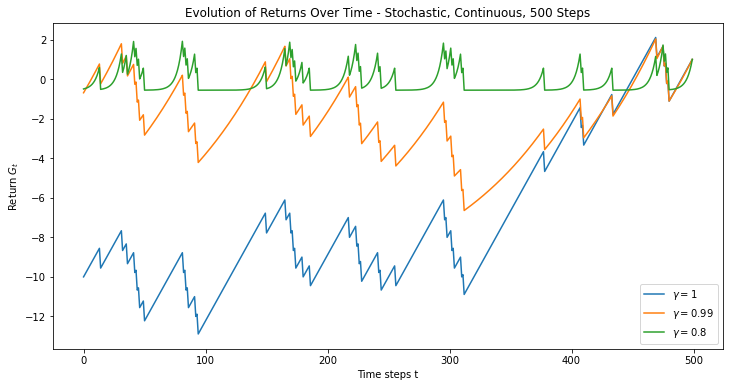

In [84]:
policy = uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions)
sequence = mdpc.sample_episode(policy, 500)
print(sequence)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

for discount in discounts:

    returns = []

    for i in range(len(sequence)):
        
        new_discount = discount 
        # First value is not discounted
        returns.append(sequence[i][2])

        # Remaining values are discounted
        for item in sequence[i+1:]:
            returns[i] += item[2]*new_discount
            new_discount *= discount

    timestep = np.arange(0,500)
    print(returns[499])
    plt.plot(timestep, returns, label=r'$\gamma=$'+str(discount))
    #a.set_title(r"Returns Vs Timesteps $\gamma = $" + str(discount))

plt.legend(loc="lower right")
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Evolution of Returns Over Time - Stochastic, Continuous, 500 Steps")

**I-c**) What is the problem of using $\gamma=1$ for this task? How was this problem solved in **b**? **---------(0.2 points)**

The problem with using $\gamma=1$ is that we require the return $G_t$ to be finite and if the task is continuous and $\gamma = 1$ then the return is infinite. We solved this problem in b by limiting the number of steps to 500.

**I-d**) Sample an episode from the episodic version of the task (implemented above as `mdpe`), under the uniform
stochastic policy
and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. **---------(0.2 points)**

Text(0.5, 1.0, 'Evolution of Returns Over Time - Episodic 500 Steps')

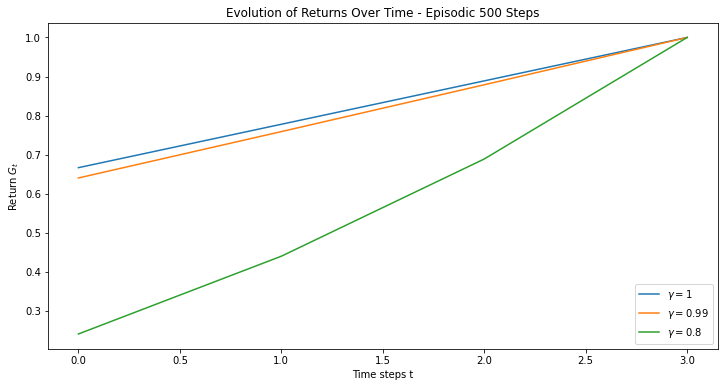

In [85]:
policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
sequence = mdpe.sample_episode(policy)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

for discount in discounts:

    returns = []

    for i in range(len(sequence)):
        
        new_discount = discount 
        # First value is not discounted
        returns.append(sequence[i][2])

        # Remaining values are discounted
        for item in sequence[i+1:]:
            returns[i] += item[2]*new_discount
            new_discount *= discount

    timestep = np.arange(0,len(sequence))
    #print(returns[499])
    plt.plot(timestep, returns, label=r'$\gamma=$'+str(discount))
    #a.set_title(r"Returns Vs Timesteps $\gamma = $" + str(discount))

plt.legend(loc="lower right")
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Evolution of Returns Over Time - Episodic 500 Steps")

**I-e**) Rerun the continuing task with a fixed $T=500$, using the pre-implemented deterministic policy and plot the
evolution of the returns $G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. **---------(0.2 points)**

[[5, 0, -0.1111111111111111], [4, 0, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.111

Text(0.5, 1.0, 'Evolution of Returns Over Time - Deterministic, Continuous, 500 Steps')

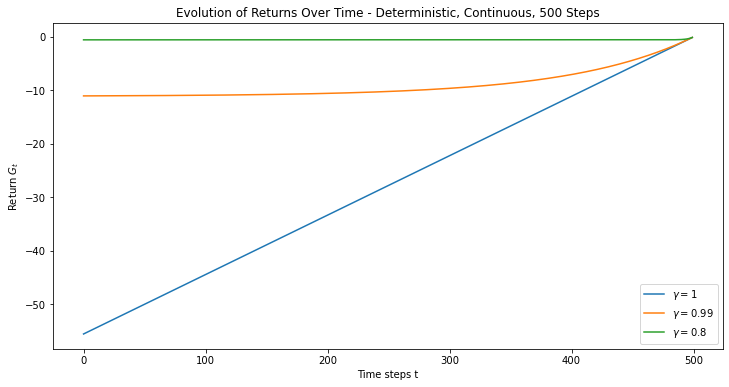

In [86]:
policy = mdpc.random_deterministic_policy()
sequence = mdpc.sample_episode(policy, 500)
print(sequence)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

for discount in discounts:

    returns = []

    for i in range(len(sequence)):
        
        new_discount = discount 
        # First value is not discounted
        returns.append(sequence[i][2])

        # Remaining values are discounted
        for item in sequence[i+1:]:
            returns[i] += item[2]*new_discount
            new_discount *= discount

    timestep = np.arange(0,500)
    #print(returns[499])
    plt.plot(timestep, returns, label=r'$\gamma=$'+str(discount))
    #a.set_title(r"Returns Vs Timesteps $\gamma = $" + str(discount))

plt.legend(loc="lower right")
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Evolution of Returns Over Time - Deterministic, Continuous, 500 Steps")

---
### II. Dynamic Programming
*(4 points)*


**II-a**) **Policy evaluation**: DP-prediction

**II-a.1**) Write a policy evaluation function, which computes the state-value function from a given policy, $v_{\pi}$. *Please complete the code below.* **---------(1 point)**

In [87]:
def policy_evaluation(mdp, policy, theta=1e-8, V=None, max_t=None):
	"""
	Iterative policy evaluation
	:param mdp: the mdp object
	:param policy: the policy to evaluate
	:param value: the value function (can be initialized)
	:param theta: cutoff for policy evaluation
	:param max_t: maximum number of steps
	Returns: State value function V
	"""
	# Conditions for convergence
	assert isinstance(mdp,CircleWorld)
	assert (mdp.task == 'episodic' or mdp.gamma < 1.0)
	# Init V
	if V is None:
		V = np.zeros(mdp.n_states)

	# Evaluate policy iteratively
	t = 0
	while True:
		delta = 0
		
		#TODO Should I only be considering nonterminal states?
		for state in mdp.nonterminal_states():
			v = V[state]
			V[state] = 0
			# Sum over actions in a particular state
			for action, prob in enumerate(policy[state]):

				# Determine new state and reward for new state
				s1, r = mdp.step(state, action)

				# Update state value
				V[state] += prob*mdp.p_transition(state, action, s1, r)*(mdp.reward[r] + mdp.gamma*V[s1]) 

			delta = max(delta, abs(v-V[state]))

		t += 1
		
		if delta < theta:
			print(f"Converged in {t} iterations")
			break

		if max_t is not None:
			if t >= max_t:
				print("Did not converge")
				break


	return V

**II-a.2**) Evaluate the optimal policy generated above, using the `policy_evaluation` function you just implemented.
Compare the value function ($v_{\pi}$) for the optimal policy with that obtained for the deterministic random policy
(pre-implemented) and for the stochastic, uniform random policy you implemented in 1a). Print or plot the results. **---------(0.4 points)**

Converged in 6 iterations
Converged in 914 iterations
Did not converge
Converged in 913 iterations
Converged in 166 iterations
Converged in 502 iterations


Text(0.5, 1.0, 'Continuous Uniform-Stoch')

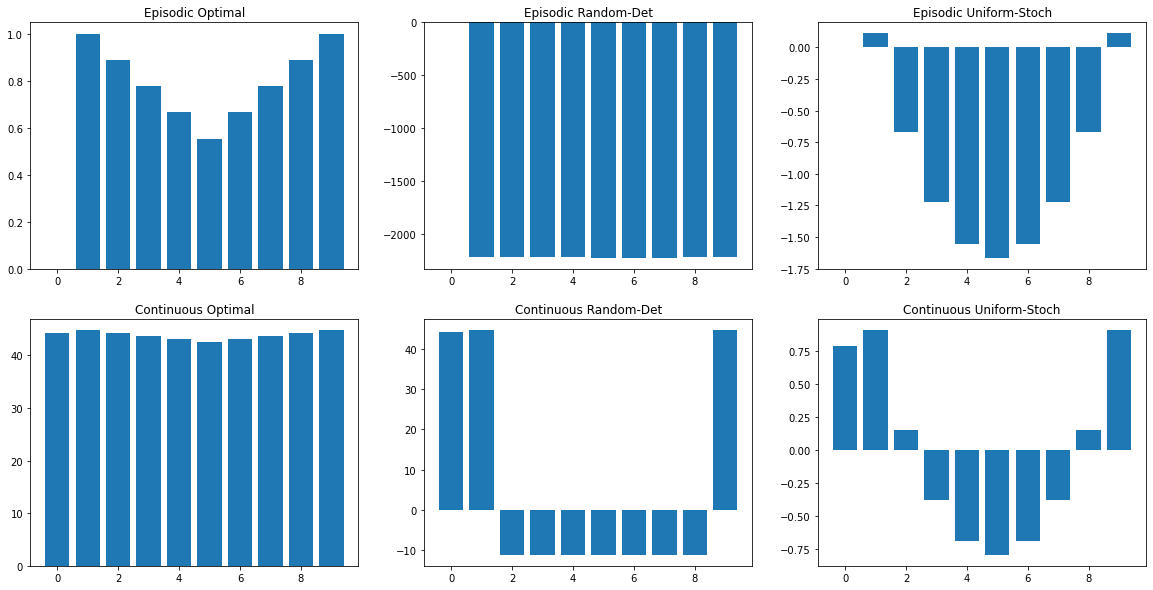

In [88]:

V1 = policy_evaluation(mdpe, mdpe.optimal_policy(), max_t=1000)
V2 = policy_evaluation(mdpc, mdpc.optimal_policy(), max_t=1000)
V3 = policy_evaluation(mdpe, mdpe.random_deterministic_policy(), max_t=10000)
V4 = policy_evaluation(mdpc, mdpc.random_deterministic_policy(), max_t=1000)
V5 = policy_evaluation(mdpe, uniform_stochastic_policy(mdpe.n_states, mdpc.n_actions), max_t=1000)
V6 = policy_evaluation(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions), max_t=1000)

xs = np.arange(0, len(V1), 1)
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0][0].bar(xs, V1)
ax[0][0].set_title("Episodic Optimal")
ax[0][1].bar(xs, V3)
ax[0][1].set_title("Episodic Random-Det")
ax[0][2].bar(xs, V5)
ax[0][2].set_title("Episodic Uniform-Stoch")

ax[1][0].bar(xs, V2)
ax[1][0].set_title("Continuous Optimal")
ax[1][1].bar(xs, V4)
ax[1][1].set_title("Continuous Random-Det")
ax[1][2].bar(xs, V6)
ax[1][2].set_title("Continuous Uniform-Stoch")


**II-a.3**) Evaluate the optimal policies for the continuing and the episodic tasks and plot the resulting value 
functions $v_{*}$. What is the main difference in state values? Why is this the case? (***Hint:*** value of State 0) **---------(0.4 points)**

See the plots in the first column of plots in the above figure. The main difference in state values is that the state values for the continuous task are much higher than the state values for the episodic task. Additionally, the value of state 0 in the episodic task is 0, while in the continuous case it is above 40. 

I'm not entirely sure why the value of State 0 is 0 in the episodic task - it is likely due to the fact that in episodic tasks terminal states always have a value of 0

**II-b**) **Policy iteration** versus **value iteration**: DP-control

The control problem is solved by following a sequence of policy *evaluation* and *improvement*:

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{0}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{1}
\stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{1}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{2}
\stackrel{\mathrm{E}}{\longrightarrow} \cdots \stackrel{\mathrm{I}}{\longrightarrow} \pi_{*}
\stackrel{\mathrm{E}}{\longrightarrow} v_{*}$$

In the exercise above, we have implemented the `policy_evaluation` step, which, given a policy $\pi$, returns the
corresponding state value function $v_{\pi}$.


**II-b.1**) Implement a `policy_improvement` function
where, given a policy and a state value function, computes action-values $q_{\pi}$ and uses those to improve the
policy by selecting the actions with the highest $q_{\pi}$ for every given state, i.e. acting greedy with respect to
the Q-values to improve the policy. **---------(1 point)**

In [114]:

# Only needs to handle deterministic policies
def policy_improvement(mdp: CircleWorld, policy, V):
	"""
	Policy improvement operates directly on the input policy.
	:param mdp:
	:param policy:
	:param V: state-value function
	returns: policy, policy_stable (bool)
	"""

	new_policy = np.full((mdp.n_states, mdp.n_actions), 0, dtype=float)


	policy_stable = True

	for state in range(mdp.n_states):

		# Place to store action values for this state
		action_values = []

		# Collect value of performing each action in this state
		for action in range(mdp.n_actions):
			s1, r = mdp.step(state, action)
			action_val = mdp.p_transition(state, action, s1, r)*(mdp.reward[r] + mdp.gamma*V[s1])
			action_values.append(action_val)

		max_val = np.max(action_values)
		# There may be multiple max_actions, so split prob evenly between them
		max_actions = np.where(action_values == max_val)[0]
		prob_per_max_action = 1/len(max_actions)

		# For each max action, assign equal probability and prob = 0 to non maximal actions
		for action in max_actions:
			new_policy[state][action] = prob_per_max_action

		# If new policy is different from old policy then policy is not stable
		if not np.array_equal(policy[state], new_policy[state]):
			policy_stable = False

	return new_policy, policy_stable

policy = uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions)
V4 = policy_evaluation(mdpc, policy, max_t=500)
new_policy, policy_stable = policy_improvement(mdpc, policy, V4)

# policy = mdpc.random_deterministic_policy()
# V4 = policy_evaluation(mdpc, policy, max_t=500)
# new_policy, policy_stable = policy_improvement(mdpc, policy, V4)

print(policy)
print(new_policy)
print(policy_stable)

Did not converge
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
False


**II-b.2**) Implement the complete `policy_iteration` algorithm by interleaving
steps of *evaluation* and *improvement*, using the functions implemented above. Note: this should be implemented as a
function that takes in an initial policy $\pi_{0}$ and returns a final (optimal) policy and a
sequence (list) of value functions. Run your *policy iteration* algorithm starting with the stochastic uniform policy,
print the resulting policy and plot the evolution of the evaluated value functions. **---------(0.6 points)**

In [90]:
def policy_iteration(mdp, policy):
	"""
	returns policy and list of value estimates per state and wall-clock time
	operates directly on the input policy
	"""
	start = time.time()
	V = None
	Vs = []

	while True:
		V = policy_evaluation(mdp, policy)
		new_policy, policy_stable = policy_improvement(mdp, policy, V)
		policy = new_policy
		if policy_stable:
			break
		Vs.append(V.copy())

	end = time.time()
	print("{0} iterations completed in {1} ms".format(len(Vs), end-start))

	return policy, Vs, end - start

In [91]:
optimized_policy_pi, value_functions_pi, timings_pi = policy_iteration(mdpc, uniform_stochastic_policy(mdpc.n_states,
                                                                                                       mdpc.n_actions))
mdpc.print_policy(optimized_policy_pi)



Converged in 502 iterations
Converged in 914 iterations
Converged in 914 iterations
2 iterations completed in 0.07560086250305176 ms
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


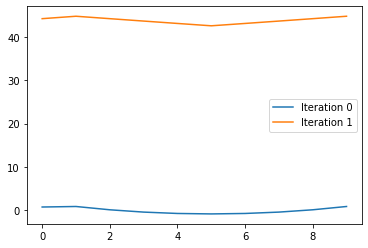

In [92]:
# plots

states = range(0, 10)
for iteration, v in enumerate(value_functions_pi):

    plt.plot(states, v, label=f"Iteration {iteration}")

plt.legend()

**II-b.3**) Implement the `value_iteration` algorithm, where you skip the policy improvement steps until you reach the
optimal value function, from which a final policy can be computed.

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{0} {\longrightarrow} v_{1} {\longrightarrow} v_{2}
{\longrightarrow} \cdots {\longrightarrow} v_{*} \rightarrow \pi_{*}$$

Note: this should be implemented as a function which starts with an all-zeros value function $v_{0}=0 \
\forall s \in \mathcal{S}$ and returns a final (optimal) policy and a sequence of value functions. To construct the
final policy, you will also need a function to construct a policy based on a state value function (this is provided below for simplicity).
Run your *value iteration* algorithm starting with the stochastic uniform policy, print
 the resulting policy and plot the evolution of the value functions. **---------(0.6 points)**

In [93]:
def policy_construction(mdp, V):
	"""
	Derive policy from value function
	"""
	policy = np.ones([mdp.n_states, mdp.n_actions]) / mdp.n_actions
	for s in range(mdp.n_states):
		action_values = np.zeros(mdp.n_actions)
		for a in range(mdp.n_actions):
			action_values[a] = sum(mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma * V[s1])
			                       for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
		best_action = np.argmax(action_values)
		# Update Policy
		policy[s, :] = 0
		policy[s, best_action] = 1
	return policy

In [94]:
def value_iteration(mdp, theta=1e-8, max_t=None):
	"""
	returns policy and list of value estimates per state
	"""
	start = time.time()

	# Evaluate policy iteratively
	t = 0
	Vs = []
	V = np.zeros(mdp.n_states)

	while True:
		delta = 0

		for state in mdp.nonterminal_states():
			v = V[state]
			V[state] = 0
	
			action_values = []

			# Collect value of performing each action in this state
			for action in range(mdp.n_actions):
				s1, r = mdp.step(state, action)
				action_val = mdp.p_transition(state, action, s1, r)*(mdp.reward[r] + mdp.gamma*V[s1])
				action_values.append(action_val)

			# Update state value
			V[state] = np.max(action_values)

			delta = max(delta, abs(v-V[state]))
		
		# Note that we need to copy V because otherwise the V stored for each iteration will all refer to the same memory location
		# and thus when you update iteration 5 values, all previous iterations will also be updated with those values
		Vs.append(V.copy())
		t += 1
		
		if delta < theta:
			print(f"Converged in {t} iterations")
			break

		if max_t is not None:
			if t >= max_t:
				print("Did not converge")
				break

	# Output deterministic policy
	policy = policy_construction(mdp, V)
	end = time.time()
	print("{0} iterations completed in {1} ms".format(len(Vs), end-start))
	return policy, Vs, end - start

In [95]:

optimized_policy_vi, value_functions_vi, timings_vi = value_iteration(mdpc)
mdpc.print_policy(optimized_policy_vi)

Converged in 914 iterations
914 iterations completed in 0.056821584701538086 ms
state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


Text(0.5, 1.0, 'State Value Vs State')

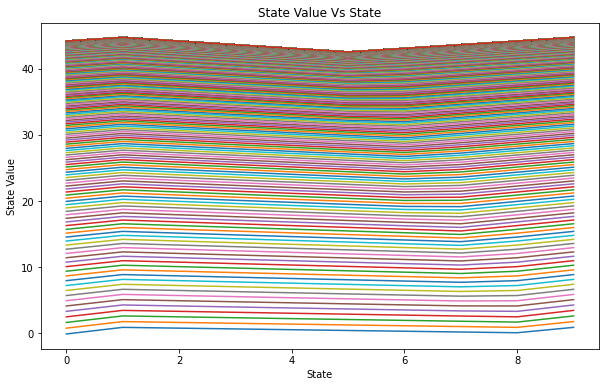

In [96]:
# plots
states = [i for i in range(10)]

plt.figure(figsize=(10,6))

for v in value_functions_vi:
    plt.plot(states, v)

plt.xlabel("State")
plt.ylabel("State Value")
plt.title("State Value Vs State")

Given that we know the ground truth for this simple problem, we can evaluate the performance of the
different algorithms by measuring how far they are from the optimal solution. So, we can calculate the Mean Squared
Error (MSE) and plot it as a function of time to see how fast and accurate are the different algorithms. **Note:** In
 this initial example, we will provide a base implementation, but this procedure will be repeated to
 evaluate the different classes of solutions (here, the MSE is plotted as a function of computing time, but in the
 model-free algorithms it will be plotted as a function of the number of episodes used).

 ***Notice:*** This is not a question.

Converged in 914 iterations
Policy MSE: 0.0 (policy iteration)
Policy MSE: 0.0 (value iteration)


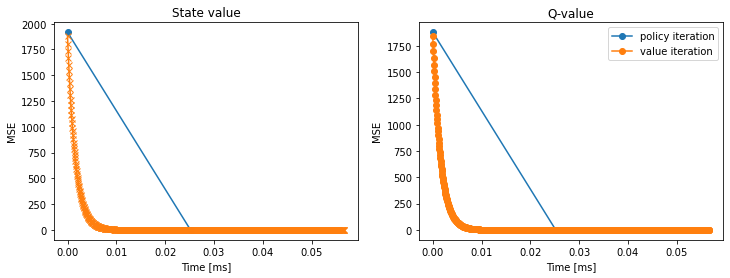

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pi_c = mdpc.optimal_policy()
V_c = policy_evaluation(mdpc, pi_c)


episode_axis = np.arange(0, timings_pi, timings_pi / (len(value_functions_pi)+1))[:len(value_functions_pi)]
ax[0].plot(episode_axis, list(map(lambda x: np.mean((x - V_c)**2), value_functions_pi)), '-o', label='policy iteration')


time_axis_vi = np.arange(0, timings_vi, timings_vi / (len(value_functions_vi)+1))[:len(value_functions_vi)]
ax[0].plot(time_axis_vi, list(map(lambda x: np.mean((x - V_c)**2), value_functions_vi)), '-x', label='value iteration')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('MSE')
ax[0].set_title('State value')

ax[1].plot(episode_axis, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_pi)),
           '-o', label='policy iteration')
ax[1].plot(time_axis_vi, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_vi)),
           '-o', label='value iteration')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('MSE')
ax[1].set_title('Q-value')
plt.legend()

print("Policy MSE: {} (policy iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_pi))**2))
print("Policy MSE: {} (value iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_vi))**2))



## Sub-assignment 3:  Monte Carlo Methods *(2 points)*



# Introduction

This Jupyter Notebook explores the implementation of Monte Carlo methods for solving Markov Decision Processes (MDPs). 

In this notebook, we will focus on the episodic version of MDPs, where the agent interacts with the environment in discrete episodes. We will start by defining a simple MDP called CircleWorld, which has a finite number of states and actions. 

We will then implement Monte Carlo methods for both prediction and control. For prediction, we will estimate the state-value function for the optimal policy using an on-policy, first-visit Monte Carlo algorithm. For control, we will optimize the policy using an on-policy, first-visit Monte Carlo algorithm and epsilon-greedy action selection.

Let's get started!

## Prerequisite

This sub-assignment is built on top of the previous sub-assignments, so it is important to complete them before, and utilize defined components in this sub-assignment. 


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

For this exercise, we will use the *episodic* version of the MDP (`mdpe` instantiated below).

In [99]:
mdpe = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1.,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpe)

task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 1.0


**a**) Why do we need to use an *episodic* task? (0.2 point)

We use an episodic task to ensure that well defined returns are available - value estimates and policies are only updated after the completion of a full episode. This allows Monte Carlo methods to update in an episode-by-episode manner, but not in a step-by-step (online) manner. If a continuous task were used it would be difficult to decide when the value function and policy should be updated.

**b**) **MC Prediction** (0.9 point): Implement an *on-policy, first-visit MC* algorithm to estimate the state-value function for
the optimal policy
. This should be provided as a function `mc_prediction` that takes in the initial policy and
 a parameter specifying how many sample episodes to run. Use your implementation to calculate the approximate state
 value function $V_{\pi}$ for the optimal policy $\pi_{*}$. Plot the MSE between the estimated value function and the
  true optimal $v_{*}$ as a function of number of episodes, i.e. how the accuracy of the estimate evolves across
  episodes.

In [100]:
def find_reversed_first_visits(episode):
	first_visits = {}
	visited_states = set()

	for index, step in enumerate(episode):
		state, action, reward = step
		if state not in visited_states:
			visited_states.add(state)
			first_visits[state] = len(episode)- 1 - index

	return first_visits



def mc_prediction(mdp: CircleWorld, policy, num_simulations=30):
	# Conditions for convergence
	assert(mdp.task == 'episodic')
	

	Vs = []
	V = [0 for i in range(10)]
	Returns = [0 for i in range(10)]
	Counts= [0 for i in range(10)]

	# Generating num_simulations episodes
	for i in range(num_simulations):

		# Generate new episode
		episode = mdp.sample_episode(policy)

		# Determine first-visit timestep for each state
		first_visits = find_reversed_first_visits(episode)

		G = 0
		
		# Iterating over steps in an episode
		for timestep, step in enumerate(reversed(episode)):
			state, action, reward = step


			G = G*mdp.gamma + reward

			# If this is the first time state is observed in sequence, then add to Returns
			if timestep == first_visits[state]:
				Returns[state] += G
				Counts[state] += 1
				V[state] = Returns[state]/Counts[state]

		Vs.append(V.copy())

	return V, Vs

In [101]:
policy = mdpe.optimal_policy()
V, value_functions_mc = mc_prediction(mdpe, policy, num_simulations=200)
print(V)

[0, 1.0, 0.8888888888888884, 0.7777777777777782, 0.6666666666666664, 0.5555555555555554, 0.6666666666666669, 0.7777777777777783, 0.8888888888888872, 1.0]


Converged in 6 iterations
[0, 1.0, 0.8888888888888884, 0.7777777777777782, 0.6666666666666664, 0.5555555555555554, 0.6666666666666669, 0.7777777777777783, 0.8888888888888872, 1.0]
[0, 1.0, 0.8888888888888884, 0.7777777777777782, 0.6666666666666664, 0.5555555555555554, 0.6666666666666669, 0.7777777777777783, 0.8888888888888873, 1.0]


Text(0.5, 1.0, 'State value')

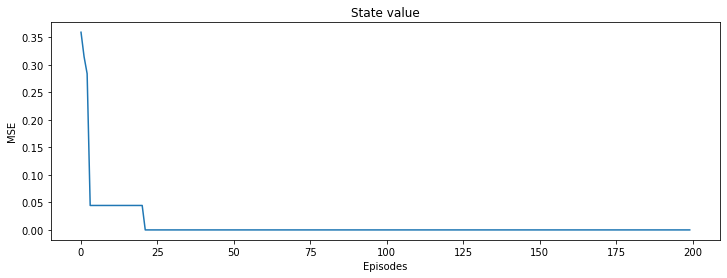

In [102]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from MC
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_e = mdpe.optimal_policy()

# True values seem to be messed up here... not sure why
# use policy evaulation on optimal policy
V_e = policy_evaluation(mdpe, pi_e)
print(value_functions_mc[199])
print(value_functions_mc[198])

episode_axis = np.arange(len(value_functions_mc))
ax.plot(episode_axis, list(map(lambda x: np.mean((x - V_e)**2), value_functions_mc)), label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('State value')
# Testing

**c**) **MC Control** (0.9 point): Implement an *on-policy, first-visit MC* algorithm to optimize the policy. To do this, you will
need to
estimate the Q-value function (computing returns after first visit to state-action pairs) and use it to take an
$\epsilon$-greedy action selection to gradually improve the policy. This should be provided as a function
`mc_control` that takes in the initial policy, the number of episodes to use and `epsilon` to set the mininum action
probability. Run for 200 episodes and plot the MSE between the estimated q-value function and the
  true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`.

In [103]:
def find_reversed_first_visits_sa(episode, mdp):

	visited_states_actions = set()
	first_visits = np.full([mdp.n_states, mdp.n_actions], -1)

	for index, step in enumerate(episode):
		state, action, reward = step
		if (state, action) not in visited_states_actions:
			visited_states_actions.add((state, action))
			first_visits[state, action] = len(episode)- 1 - index

	return first_visits


def mc_control(mdp, policy, num_simulations=30, epsilon=0.01):
	"""
	Run the Monte Carlo First Visit On-Policy algorithm and return the estimated
	policy, Q (state action) values, and returns (rewards) dict.
	Uses epsilon-soft policies instead of exploring starts
	:param mdp:
	:param policy: any epsilon soft policy; e.g. mdp.uniform_stochastic_policy()
	:param num_simulations : int Number of episodes for the policy iteration process
	:param epsilon: epsilon-soft minimum probability

	:return policy: numpy.ndarray Estimated Policy
	:return Q: numpy.ndarray Estimated Q (state-action) values
	:return R: dict Returns obtained for every state
	"""
	# Conditions for convergence
	assert(mdp.task == 'episodic')
	assert isinstance(mdp, CircleWorld)

	Qs = []
	Q = np.zeros([mdp.n_states, mdp.n_actions])
	Returns = np.zeros([mdp.n_states, mdp.n_actions])
	Counts= np.zeros([mdp.n_states, mdp.n_actions])

	# Generating num_simulations episodes
	for i in range(num_simulations):

		# Generate new episode
		episode = mdp.sample_episode(policy)

		# Determine first-visit timestep for each state
		first_visits = find_reversed_first_visits_sa(episode, mdp)

		G = 0
		
		# Iterating over steps in an episode
		for timestep, step in enumerate(reversed(episode)):
			state, action, reward = step

			G = G*mdp.gamma + reward

			# If this is the first time state is observed in sequence, then add to Returns
			if timestep == first_visits[state, action]:
				Returns[state, action] += G
				Counts[state, action] += 1
				Q[state, action] = Returns[state, action]/Counts[state, action]

				# Update policy
				a_star = np.argmax(Q[state])
				for action in range(mdp.n_actions):
					if action == a_star:
						policy[state][action] = 1 - epsilon + epsilon/(mdp.n_actions)
					else:
						policy[state][action] = epsilon/(mdp.n_actions)

		Qs.append(Q.copy())

	return policy, Qs

compare with uniform stochastic policy in the previous part

In [104]:
policy0 = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_mc, Qs_mc = mc_control(mdpe, policy0, num_simulations=200, epsilon=0.01)
print(policy_mc)

[[0.5   0.5  ]
 [0.995 0.005]
 [0.995 0.005]
 [0.995 0.005]
 [0.995 0.005]
 [0.005 0.995]
 [0.005 0.995]
 [0.005 0.995]
 [0.005 0.995]
 [0.005 0.995]]


Converged in 6 iterations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


Text(0.5, 1.0, 'MSE vs Episodes for Q Function')

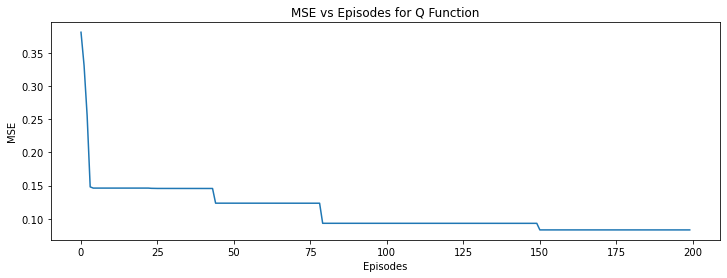

In [105]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from MC
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_star = mdpe.optimal_policy()

v_star = policy_evaluation(mdpe, pi_star)
q_star = mdpe.v_to_q(v_star)

episode_axis = np.arange(len(Qs_mc))
print(episode_axis)
ax.plot(episode_axis, list(map(lambda x: np.mean((x - q_star)**2), Qs_mc)), label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('MSE vs Episodes for Q Function')

## Sub-assignment 4:  TD Learning *(3 points)*



### Introduction

This Jupyter Notebook explores the implementation of TD learning. TD learning, short for Temporal Difference learning, is a reinforcement learning algorithm that combines elements of both Monte Carlo methods and dynamic programming.

In this notebook, we will focus on three different TD methods: TD prediction, on-policy TD control, and off-policy TD control. We will implement and run these algorithms on a specific environment called CircleWorld.

The CircleWorld environment is a grid-like world where an agent can move in four directions: up, down, left, and right. The goal of the agent is to navigate through the world and reach a specific target state. The environment is episodic, meaning that each episode starts from a specific initial state and ends when the agent reaches the target state.

We will start by implementing TD prediction, which aims to estimate the value function under the optimal policy. We will run the TD(0) algorithm for a fixed number of sample episodes and observe how the accuracy of the value function estimate evolves across episodes.

Next, we will move on to on-policy TD control, where we will implement and run the SARSA algorithm. SARSA is an on-policy control algorithm that estimates the optimal policy by updating the action-value function based on the agent's experience. We will start with a uniform stochastic policy and gradually improve it through the SARSA algorithm.

Finally, we will explore off-policy TD control using the Q-learning algorithm. Q-learning is an off-policy control algorithm that estimates the optimal policy by updating the action-value function based on the maximum Q-value of the next state. We will start with a uniform stochastic policy and observe how the estimated Q-values evolve across episodes.

Throughout this notebook, we will plot the results of each algorithm to visualize the learning progress and compare the performance of different TD methods.



Let's get started!

### Prerequisite

This sub-assignment is built on top of the previous sub-assignments, so it is important to complete them before, and utilize defined components in this sub-assignment. 

Note that, despite the fact that TD-learning can handle continuing tasks, we will constrain the study to episodic
tasks because the nature of the environment would result in infinite loops where no stable solutions can be found.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

**a**) **TD Prediction**: Implement and run TD(0) to estimate the value function under the optimal policy. Run the
algorithm for 500 sample episodes with a fixed $\alpha=0.01$. Plot the result as the MSE between the state
 value estimates $V$ and the ground truth $v_{\pi}$ as a function of number of episodes, i.e. how
 the accuracy of the estimate evolves across
  episodes.

In [107]:
def td0_prediction(mdp, policy, num_simulations=30, alpha = 0.01):
	"""
	TD(0) prediction algorithm
	:param mdp:
	:param policy:
	:param num_simulations: number of episodes to sample
	:param alpha: fixed learning rate
	:return:
	"""
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')
	assert isinstance(mdp, CircleWorld)

	V = np.zeros(mdp.n_states)
	Vs = []
	for i in range(num_simulations):

		# Randomly start from a non-terminal state
		state = np.random.randint(1, 10)

		while True:

			action = mdp.sample_action(state, policy)
			new_state, reward = mdp.step(state, action)
			V[state] = V[state] + alpha*(mdp.reward[reward] + mdp.gamma*V[new_state] - V[state])
			state = new_state

			# If we reach a terminal state, we should break out
			if state == 0:
				break
		
		Vs.append(V.copy())

	return V, Vs

In [108]:
td_v, td_vs = td0_prediction(mdpe, mdpe.optimal_policy(), num_simulations=500, alpha=0.01)
print (td_v)

[ 0.          0.89367182  0.50190123  0.10986482 -0.04261468 -0.07573394
 -0.04072222  0.19326361  0.60569736  0.93820563]


Converged in 6 iterations
[0.         1.         0.88888889 0.77777778 0.66666667 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


Text(0.5, 1.0, 'MSE vs Episodes for TD(0) Value Function')

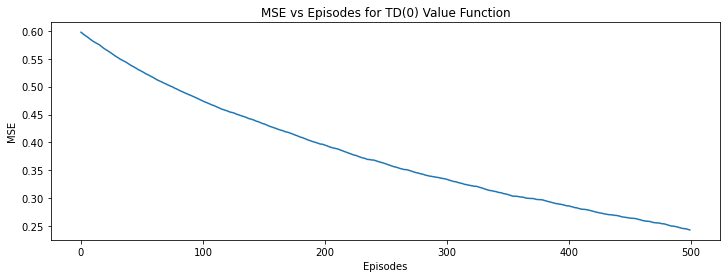

In [109]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from TD
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_star = mdpe.optimal_policy()

v_star = policy_evaluation(mdpe, pi_star)
print(v_star)

episode_axis = np.arange(len(td_vs))
ax.plot(episode_axis, list(map(lambda x: np.mean((x - v_star)**2), td_vs)), label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('MSE vs Episodes for TD(0) Value Function')

**b**) **On-policy TD control**: Implement and run the SARSA algorithm to estimate the optimal policy. Remember
that policy updates are $\epsilon$-greedy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`.

In [110]:
def make_epsilon_greedy_policy(mdp, Q, epsilon, policy):

	assert isinstance(mdp, CircleWorld)
	# Update policy

	for state in range(mdp.n_states):
		a_star = np.argmax(Q[state])
		for action in range(mdp.n_actions):
			if action == a_star:
				policy[state][action] = 1 - epsilon + epsilon/(mdp.n_actions)
			else:
				policy[state][action] = epsilon/(mdp.n_actions)
	
	return policy

In [111]:
def sarsa(mdp, num_simulations=30, alpha=0.01, epsilon=0.1):
	"""
	SARSA on-policy control
	:param mdp:
	:param num_simulations: number of sample episodes
	:param alpha: learning rate
	:param epsilon: minimum action selection probability
	:return:
	"""
	# Conditions for convergence; note that we can also run on continuing problems
	assert (mdp.task == 'episodic')
	assert isinstance(mdp, CircleWorld)
	Q = np.zeros([mdp.n_states, mdp.n_actions])
	policy = uniform_stochastic_policy(mdp.n_states, mdp.n_actions)
	Qs = []
	
	for i in range(num_simulations):

		# Randomly start from a non-terminal state
		state = np.random.randint(1, 10)
		action = mdp.sample_action(state, policy)


		while True:

			new_state, reward = mdp.step(state, action)
			new_action = mdp.sample_action(new_state, policy)
			Q[state][action] = Q[state][action] + alpha*(mdp.reward[reward] + mdp.gamma*Q[new_state][new_action] - Q[state][action])
			

			# Update policy
			a_star = np.argmax(Q[state])
			for action in range(mdp.n_actions):
				if action == a_star:
					policy[state][action] = 1 - epsilon + epsilon/(mdp.n_actions)
				else:
					policy[state][action] = epsilon/(mdp.n_actions)


			state = new_state
			action = new_action

			# If we reach a terminal state, we should break out
			if state == 0:
				break
		
		Qs.append(Q.copy())

	return policy, Q, Qs

In [112]:
policy_sarsa, Q, Qs_sarsa = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)
print(Q)

[[0.         0.        ]
 [1.         0.62770934]
 [0.87597688 0.47786771]
 [0.73854849 0.25973614]
 [0.6076978  0.07458375]
 [0.17001391 0.48033877]
 [0.15733502 0.62040248]
 [0.36243354 0.75635823]
 [0.53632435 0.87818412]
 [0.68884678 1.        ]]


Converged in 6 iterations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


ValueError: x and y must have same first dimension, but have shapes (200,) and (10000,)

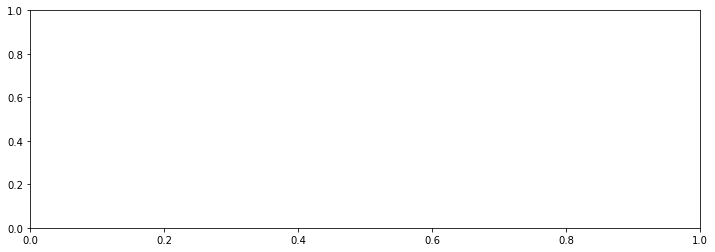

In [113]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from MC
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_star = mdpe.optimal_policy()

v_star = policy_evaluation(mdpe, pi_star)
q_star = mdpe.v_to_q(v_star)

episode_axis = np.arange(len(Qs_mc))
print(episode_axis)
ax.plot(episode_axis, list(map(lambda x: np.mean((x - q_star)**2), Qs_sarsa)), label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('MSE vs Episodes for Q Function SARSA')

**c**) **Off-policy TD control**: Implement and run the Q-learning algorithm to estimate the optimal policy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes.

In [ ]:
def qlearning(mdp, behavioral_policy, num_simulations=30, alpha=0.01, epsilon=0.1):
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])
	Qs = []

	for t in range(num_simulations):
		s = mdp.reset()
		while not mdp.is_terminal(s):
			a = mdp.sample_action(s, behavioral_policy)
			(s1, r) = mdp.step(s, a)

			Q[s][a] = Q[s][a] + alpha*(mdp.reward[r] + mdp.gamma*max(Q[s1]) - Q[s][a])
			s = s1

		Qs.append(copy.copy(Q))
	# determine policy from Q function
	target_policy = np.zeros([mdp.n_states, mdp.n_actions])
	for state in mdp.terminal_states():
		target_policy[state,:] = 1.0 / mdp.n_actions
	for state in mdp.nonterminal_states():
		a_max = np.random.choice(np.flatnonzero(Q[state] == np.max(Q[state])))
		target_policy[state, a_max] = 1.0

	return target_policy, Q, Qs

In [ ]:
b_policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_Q, Q, Qs_qlearning = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=10000, alpha=0.01)
print(Q)

[[0.         0.        ]
 [1.         0.77777778]
 [0.88888889 0.66666667]
 [0.77777778 0.55555556]
 [0.66666667 0.44444444]
 [0.55555556 0.55555556]
 [0.44444444 0.66666667]
 [0.55555556 0.77777778]
 [0.66666667 0.88888889]
 [0.77777778 1.        ]]


Converged in 6 iterations
[   0    1    2 ... 9997 9998 9999]


Text(0.5, 1.0, 'MSE vs Episodes for Q Function Q-Learning')

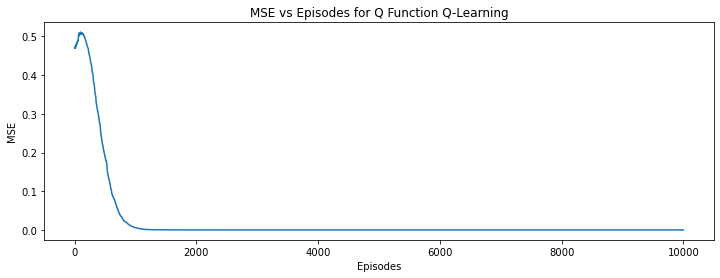

In [ ]:
# plots
# Somehow need to get the true value of the optimal policy to compare it with the value of the approximation from MC
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pi_star = mdpe.optimal_policy()
 
v_star = policy_evaluation(mdpe, pi_star)
q_star = mdpe.v_to_q(v_star)

episode_axis = np.arange(len(Qs_mc))
print(episode_axis)
ax.plot(episode_axis, list(map(lambda x: np.mean((x - q_star)**2), Qs_qlearning)), label='policy iteration')
ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
ax.set_title('MSE vs Episodes for Q Function Q-Learning')